Remove Outliers ÔºàCalibrationÔºâ

‚úÖ Cleaned calibration data saved to 'calibration_cleaned.csv'


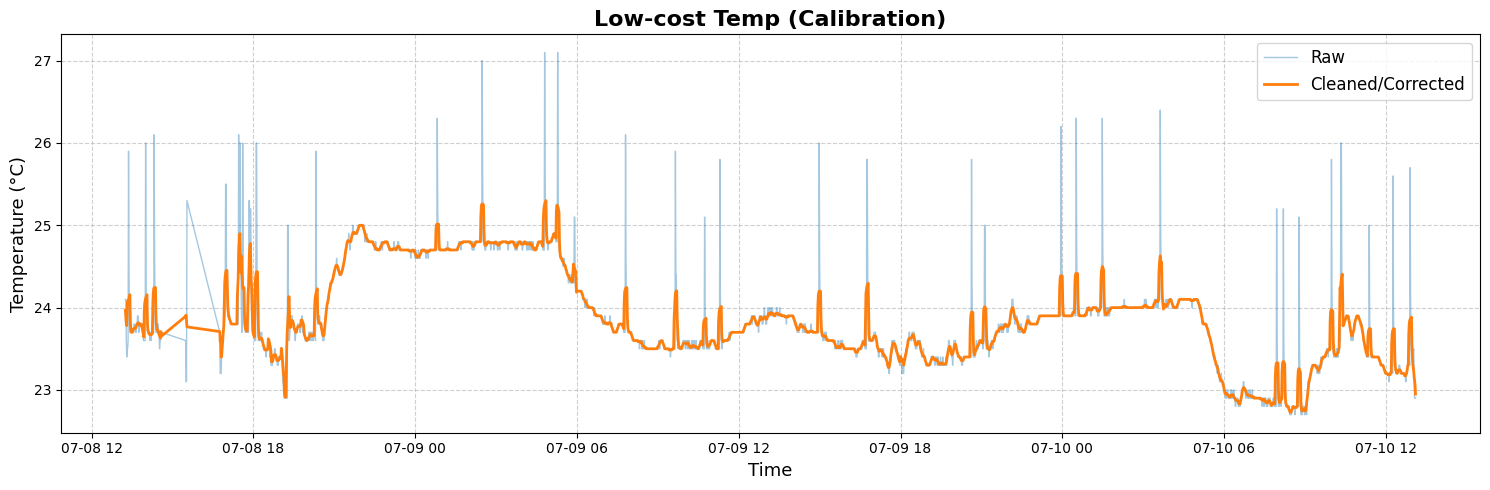

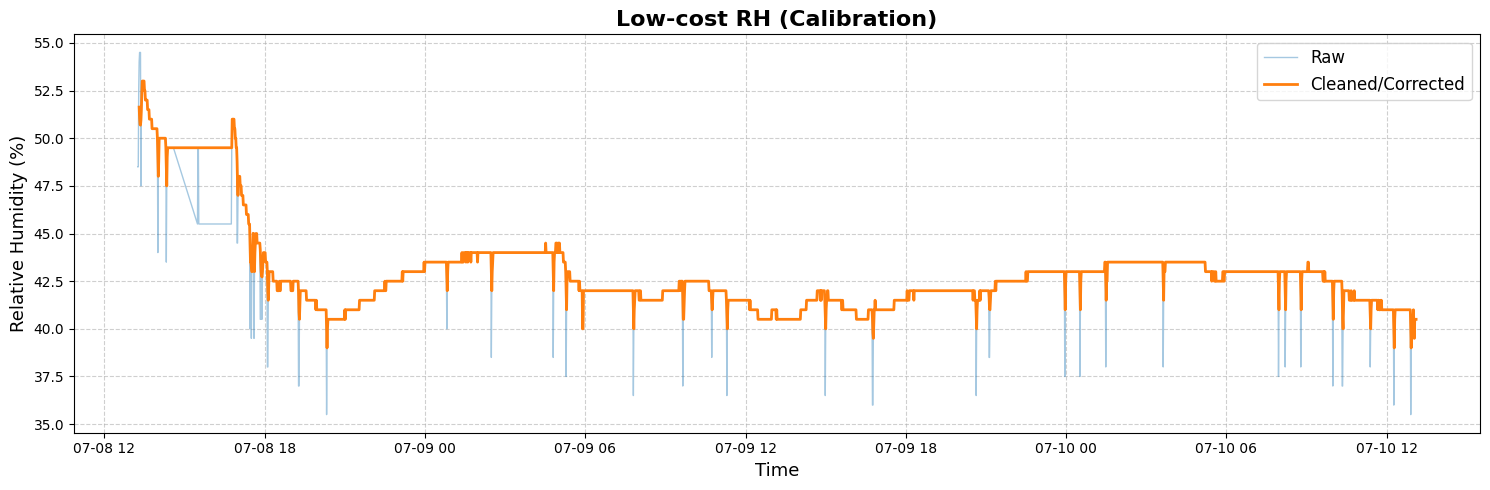

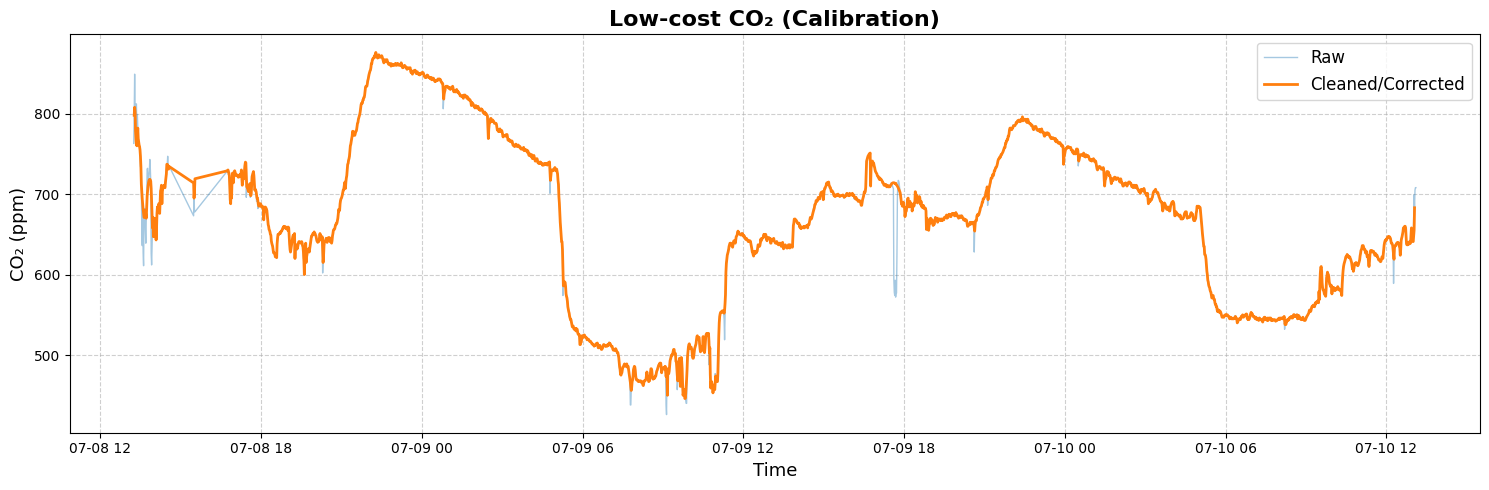

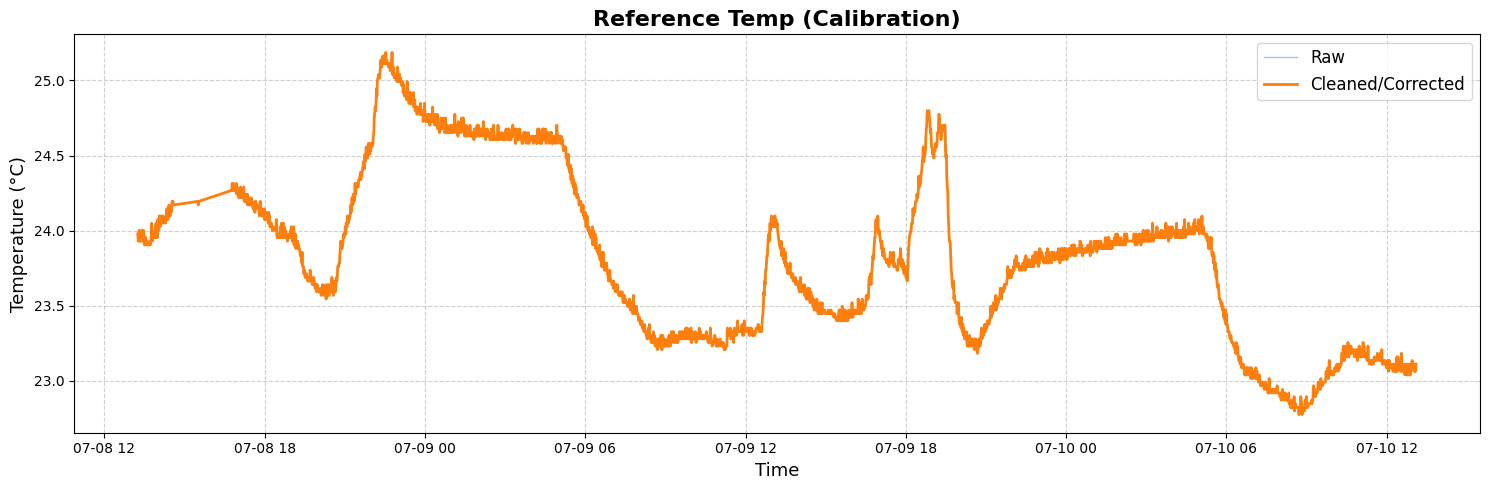

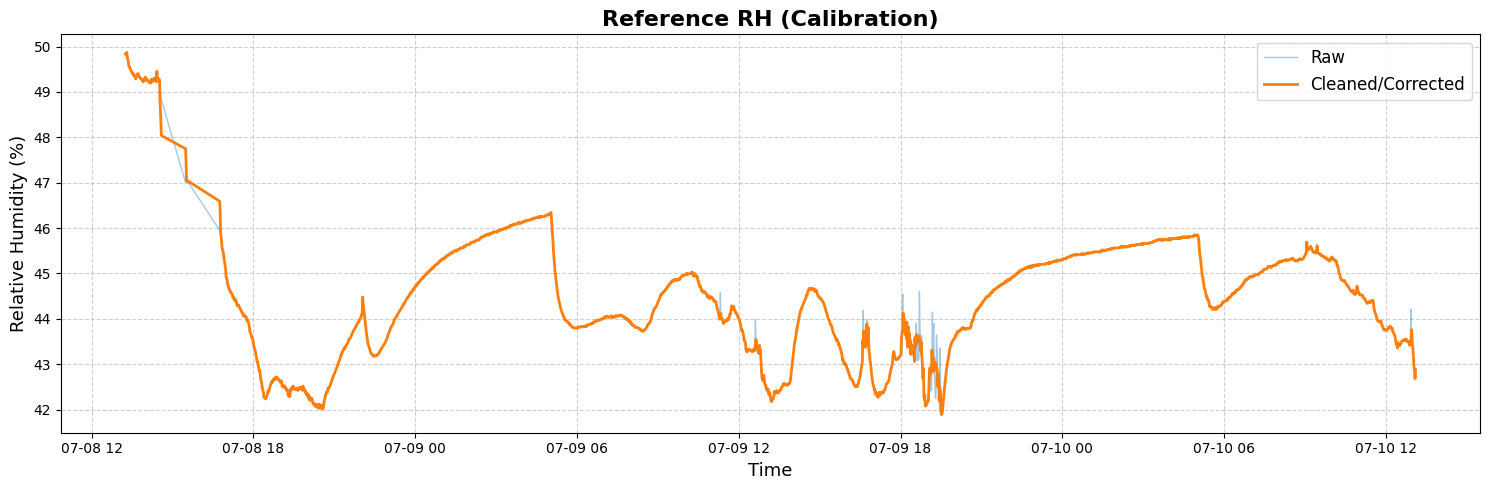

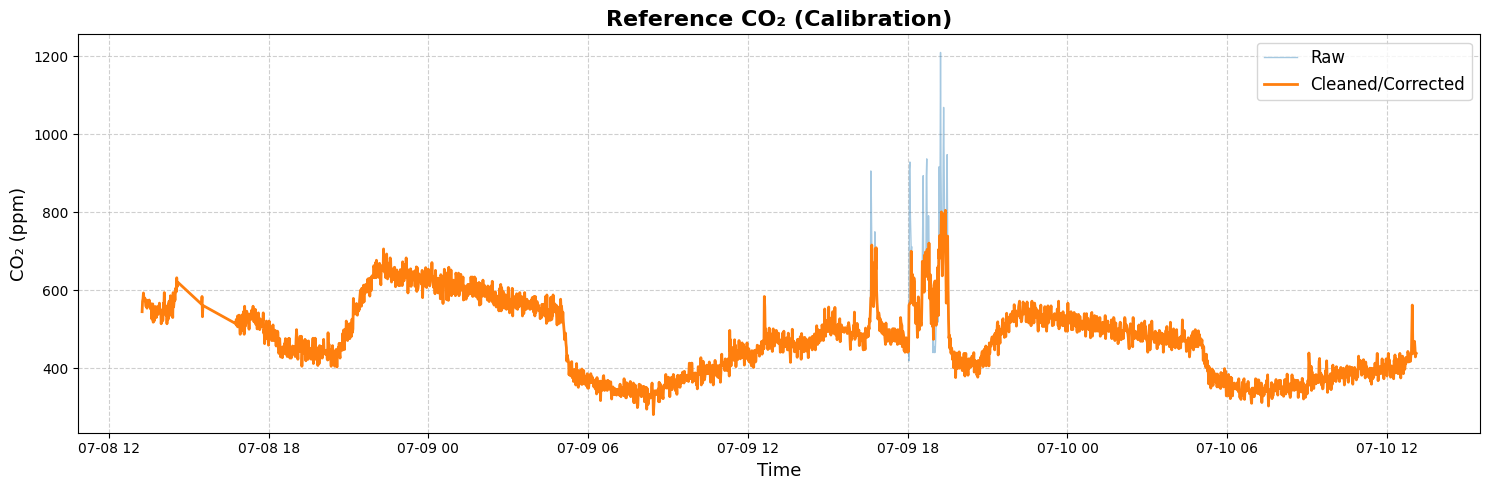

üå° Low-cost Temp: Raw = 2740, Valid = 2740 (100.0%)
üíß Low-cost RH: Raw = 2740, Valid = 2737 (99.9%)
üåÄ Low-cost CO‚ÇÇ: Raw = 2740, Valid = 2735 (99.8%)
üå° Reference Temp: Raw = 2740, Valid = 2740 (100.0%)
üíß Reference RH: Raw = 2740, Valid = 2740 (100.0%)
üåÄ Reference CO‚ÇÇ: Raw = 2740, Valid = 2740 (100.0%)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ------------------------
# 1. Load Data
# ------------------------
file_path = 'calibration.csv'
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'])
time = df['DateTime']

# ------------------------
# 2. Define Cleaning FunctionsÔºàÂº∫ÂåñÁâàÔºâ
# ------------------------
def smooth_and_detect(series, window_length, polyorder, threshold, delete=True):
    series = pd.Series(series, dtype=float)
    if len(series) < window_length:
        return series.copy().to_numpy()
    smooth_series = savgol_filter(series, window_length=window_length, polyorder=polyorder, mode='interp')
    residual = series - smooth_series
    std = np.std(residual)
    mask = np.abs(residual) < threshold * std
    cleaned = series.copy()
    if delete:
        cleaned[~mask] = np.nan
        cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    else:
        cleaned[~mask] = smooth_series[~mask]
    return cleaned.to_numpy()

def spike_removal(series, window=3, threshold=2.0):
    series = pd.Series(series, dtype=float)
    diff = series.diff().abs()
    rolling_median = diff.rolling(window=window, center=True, min_periods=1).median()
    mask = (diff < threshold * rolling_median) | (rolling_median == 0)
    cleaned = series.copy()
    cleaned[~mask] = np.nan
    cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    return cleaned.to_numpy()

def rolling_mean_detect(series, window, threshold, delete=True):
    series = pd.Series(series, dtype=float)
    rolling_mean = series.rolling(window, center=True, min_periods=1).mean()
    residual = series - rolling_mean
    std = np.std(residual)
    mask = np.abs(residual) < threshold * std
    cleaned = series.copy()
    if delete:
        cleaned[~mask] = np.nan
        cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    else:
        cleaned[~mask] = rolling_mean[~mask]
    return cleaned.to_numpy()

# ‚úÖ Temperature‰∏ìÁî®Ê∏ÖÊ¥ó
def clean_temperature(series, window_length=25, polyorder=2, spike_window=3, spike_threshold=2.0, smooth_window=7):
    series = pd.Series(series, dtype=float)
    smooth_series = savgol_filter(series, window_length=window_length, polyorder=polyorder, mode='interp')
    diff = series.diff().abs()
    rolling_median = diff.rolling(window=spike_window, center=True, min_periods=1).median()
    spike_mask = (diff < spike_threshold * rolling_median) | (rolling_median == 0)
    cleaned = series.copy()
    cleaned[~spike_mask] = np.nan
    cleaned = cleaned.interpolate(method='spline', order=2, limit=5, limit_direction='both')
    cleaned = pd.Series(cleaned).rolling(window=smooth_window, center=True, min_periods=1).mean()
    return cleaned.to_numpy()

# ------------------------
# 3. Apply to Low-cost Sensor (Calibration)
# ------------------------

# ‚úÖ Temperature (Low-cost) ‚Äî ÂèåÈáçÊ∏ÖÊ¥ó
temp_m_clean = clean_temperature(df['Temp_C_m'])

# Humidity (Low-cost)
rh_m_stage1 = smooth_and_detect(df['RH_%_m'], window_length=21, polyorder=2, threshold=3.0, delete=True)
rh_m_clean = spike_removal(rh_m_stage1, window=3, threshold=2.0)

# CO2 (Low-cost)
co2_m_stage1 = rolling_mean_detect(df['CO2_ppm_m'], window=21, threshold=3.0, delete=True)
co2_m_clean = spike_removal(co2_m_stage1, window=3, threshold=2.5)

# ------------------------
# 4. Apply to Reference Sensor (Correction only)
# ------------------------
temp_r_clean = smooth_and_detect(df['Temp_C'], window_length=31, polyorder=2, threshold=4.5, delete=False)
rh_r_clean = smooth_and_detect(df['RH_%'], window_length=25, polyorder=2, threshold=4.0, delete=False)
co2_r_clean = rolling_mean_detect(df['CO2_ppm'], window=31, threshold=4.0, delete=False)

# ------------------------
# 5. Save Cleaned Data
# ------------------------
clean_df = pd.DataFrame({
    'DateTime': time,
    'Temp_C': temp_r_clean,
    'RH_%': rh_r_clean,
    'CO2_ppm': co2_r_clean,
    'Temp_C_m': temp_m_clean,
    'RH_%_m': rh_m_clean,
    'CO2_ppm_m': co2_m_clean
})
clean_df.to_csv('calibration_cleaned.csv', index=False)
print("‚úÖ Cleaned calibration data saved to 'calibration_cleaned.csv'")

# ------------------------
# 6. Plot Function
# ------------------------
def plot_sensor(time, raw, clean, ylabel, title, filename):
    plt.figure(figsize=(15, 5))
    plt.plot(time, raw, label='Raw', alpha=0.4, linewidth=1)
    plt.plot(time, clean, label='Cleaned/Corrected', linewidth=2)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel(ylabel, fontsize=13)
    plt.xlabel('Time', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# ------------------------
# 7. Plot Low-cost Sensor
# ------------------------
plot_sensor(time, df['Temp_C_m'], temp_m_clean, 'Temperature (¬∞C)', 'Low-cost Temp (Calibration)', 'temp_lowcost_calib.png')
plot_sensor(time, df['RH_%_m'], rh_m_clean, 'Relative Humidity (%)', 'Low-cost RH (Calibration)', 'rh_lowcost_calib.png')
plot_sensor(time, df['CO2_ppm_m'], co2_m_clean, 'CO‚ÇÇ (ppm)', 'Low-cost CO‚ÇÇ (Calibration)', 'co2_lowcost_calib.png')

# ------------------------
# 8. Plot Reference Sensor
# ------------------------
plot_sensor(time, df['Temp_C'], temp_r_clean, 'Temperature (¬∞C)', 'Reference Temp (Calibration)', 'temp_ref_calib.png')
plot_sensor(time, df['RH_%'], rh_r_clean, 'Relative Humidity (%)', 'Reference RH (Calibration)', 'rh_ref_calib.png')
plot_sensor(time, df['CO2_ppm'], co2_r_clean, 'CO‚ÇÇ (ppm)', 'Reference CO‚ÇÇ (Calibration)', 'co2_ref_calib.png')

# ------------------------
# 9. Print Summary
# ------------------------
def print_stats(raw, clean, name):
    total = len(raw)
    valid = np.sum(~np.isnan(clean))
    percent = valid / total * 100
    print(f"{name}: Raw = {total}, Valid = {valid} ({percent:.1f}%)")

print_stats(df['Temp_C_m'], temp_m_clean, "üå° Low-cost Temp")
print_stats(df['RH_%_m'], rh_m_clean, "üíß Low-cost RH")
print_stats(df['CO2_ppm_m'], co2_m_clean, "üåÄ Low-cost CO‚ÇÇ")
print_stats(df['Temp_C'], temp_r_clean, "üå° Reference Temp")
print_stats(df['RH_%'], rh_r_clean, "üíß Reference RH")
print_stats(df['CO2_ppm'], co2_r_clean, "üåÄ Reference CO‚ÇÇ")

Remove Outliers(validation)

‚úÖ Cleaned validation data saved to 'validation_cleaned.csv'


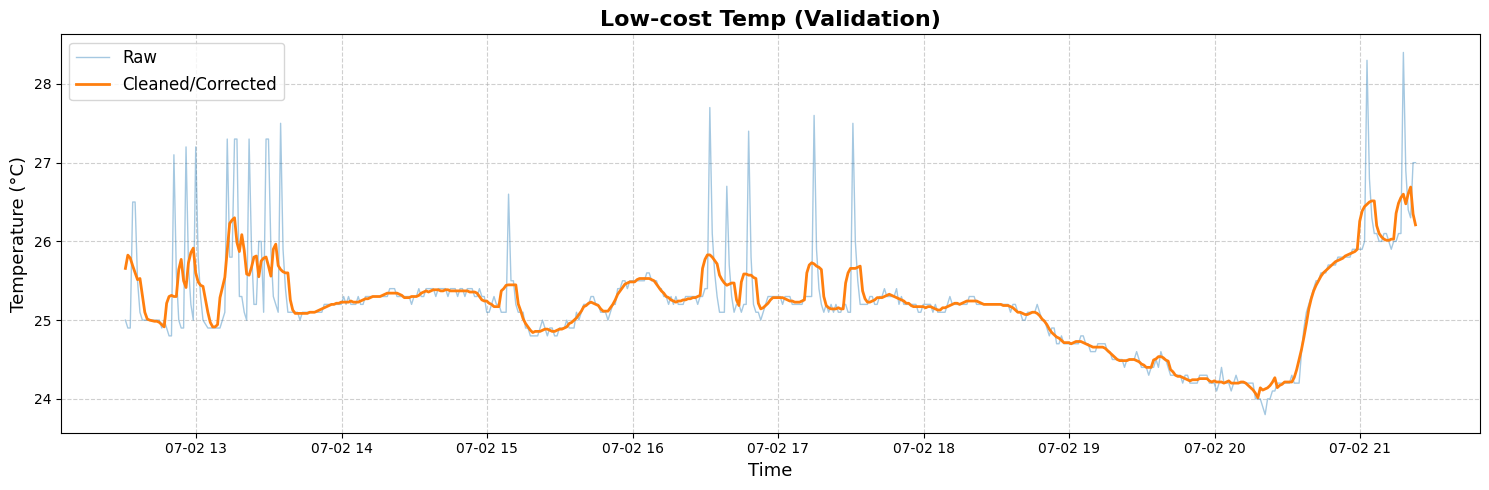

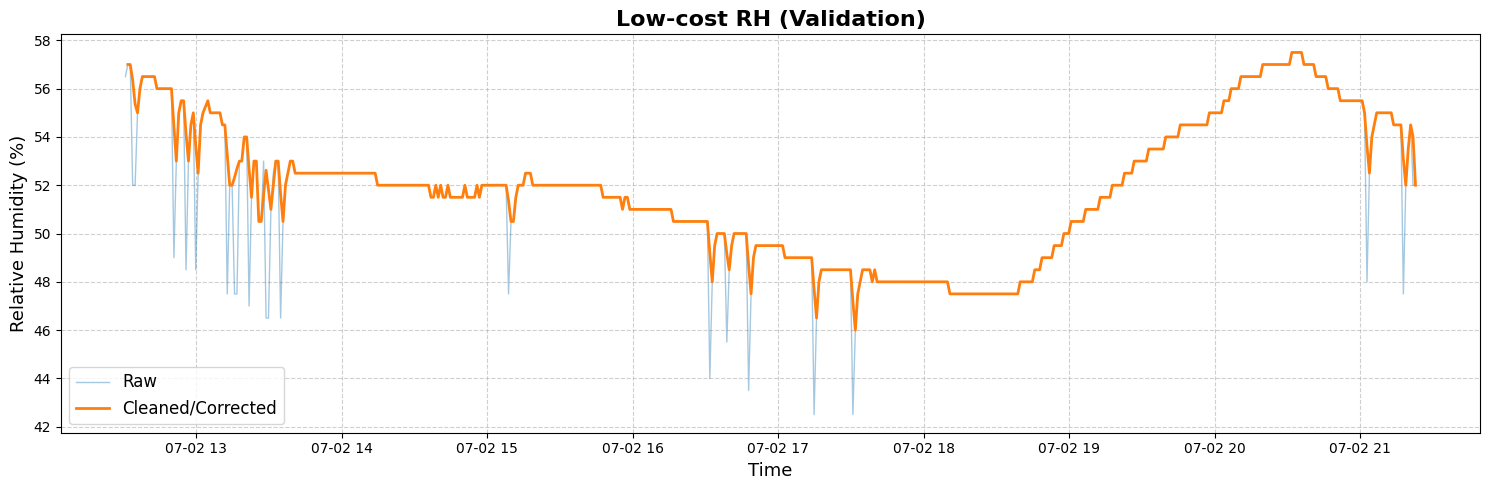

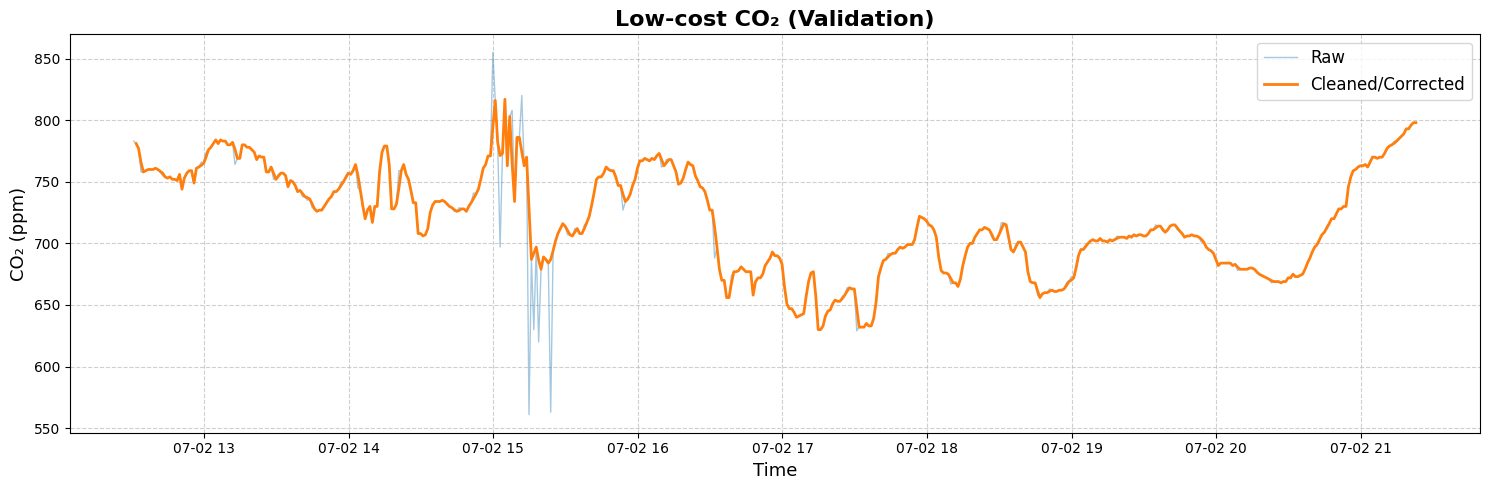

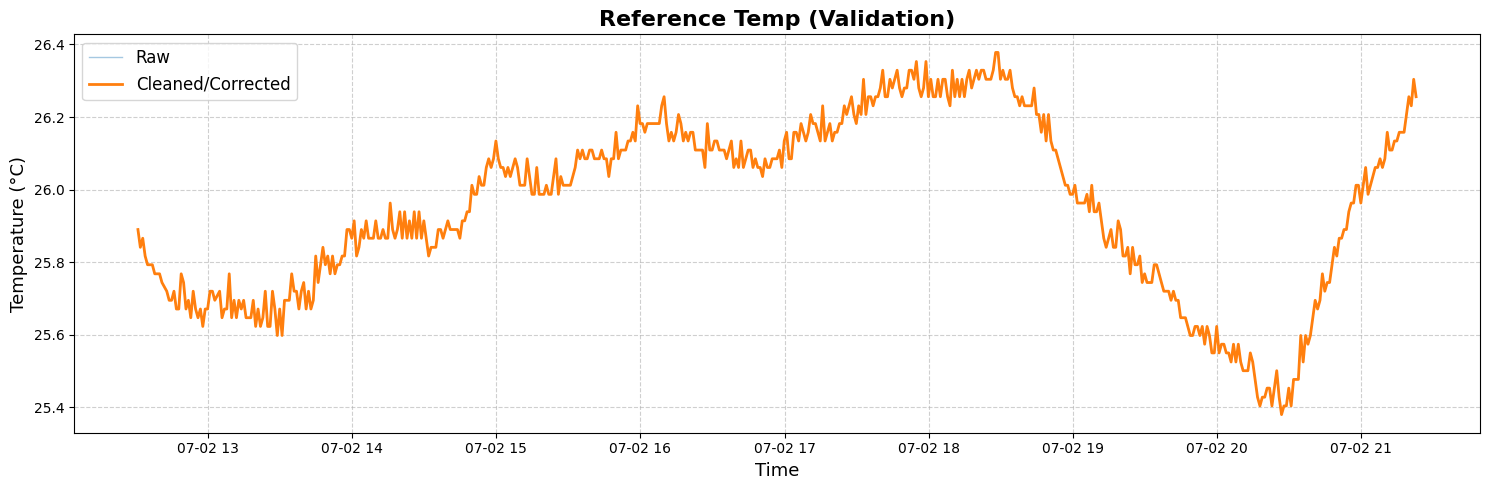

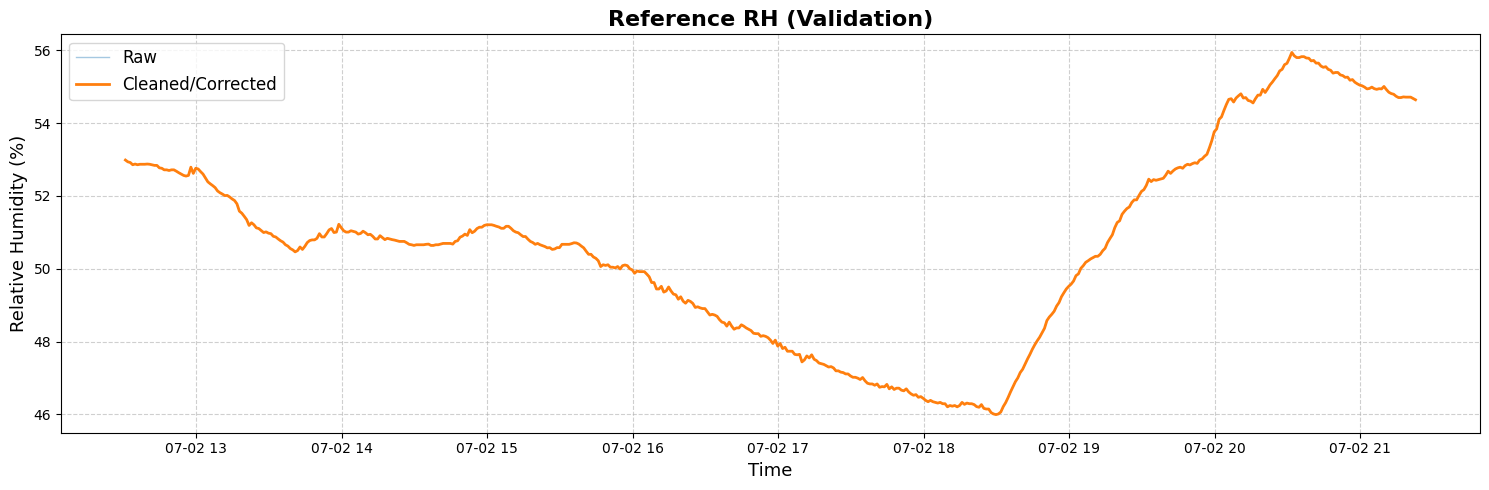

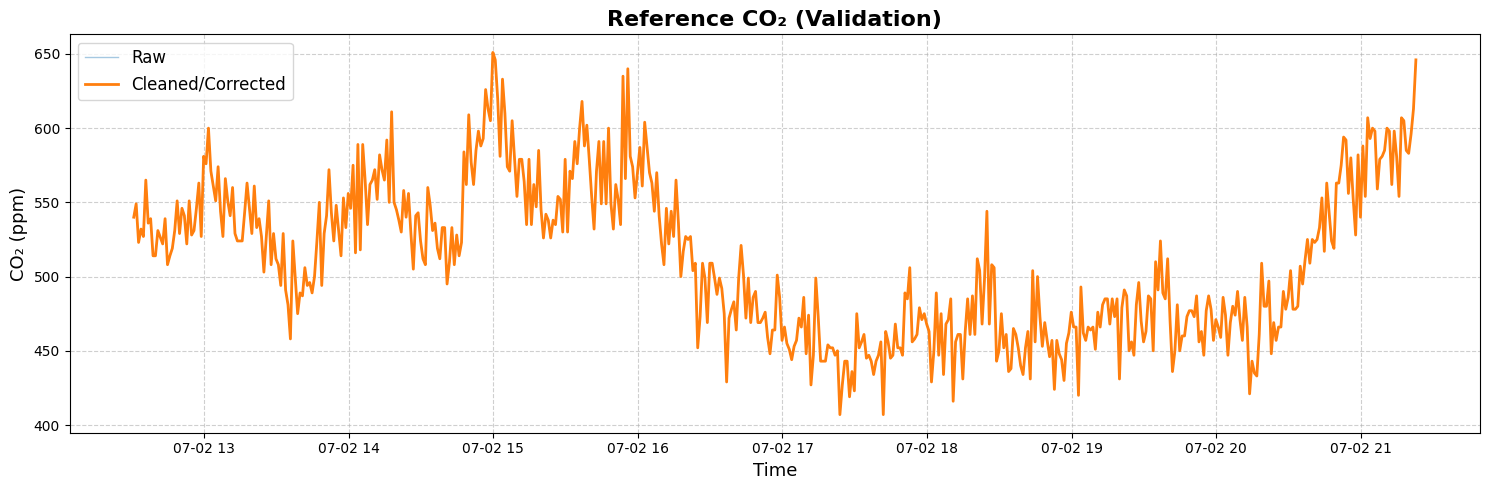

üå° Low-cost Temp (Validation): Raw = 530, Valid = 530 (100.0%)
üíß Low-cost RH (Validation): Raw = 530, Valid = 529 (99.8%)
üåÄ Low-cost CO‚ÇÇ (Validation): Raw = 530, Valid = 529 (99.8%)
üå° Reference Temp (Validation): Raw = 530, Valid = 530 (100.0%)
üíß Reference RH (Validation): Raw = 530, Valid = 530 (100.0%)
üåÄ Reference CO‚ÇÇ (Validation): Raw = 530, Valid = 530 (100.0%)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ------------------------
# 1. Load Validation Data
# ------------------------
file_path = 'validation.csv'
df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'])
time = df['DateTime']

# ------------------------
# 2. Define Cleaning Functions (Âº∫ÂåñÁâà)
# ------------------------
def smooth_and_detect(series, window_length, polyorder, threshold, delete=True):
    series = pd.Series(series, dtype=float)
    if len(series) < window_length:
        return series.copy().to_numpy()
    smooth_series = savgol_filter(series, window_length=window_length, polyorder=polyorder, mode='interp')
    residual = series - smooth_series
    std = np.std(residual)
    mask = np.abs(residual) < threshold * std
    cleaned = series.copy()
    if delete:
        cleaned[~mask] = np.nan
        cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    else:
        cleaned[~mask] = smooth_series[~mask]
    return cleaned.to_numpy()

def spike_removal(series, window=3, threshold=2.5):
    series = pd.Series(series, dtype=float)
    diff = series.diff().abs()
    rolling_median = diff.rolling(window=window, center=True, min_periods=1).median()
    mask = (diff < threshold * rolling_median) | (rolling_median == 0)
    cleaned = series.copy()
    cleaned[~mask] = np.nan
    cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    return cleaned.to_numpy()

def rolling_mean_detect(series, window, threshold, delete=True):
    series = pd.Series(series, dtype=float)
    rolling_mean = series.rolling(window, center=True, min_periods=1).mean()
    residual = series - rolling_mean
    std = np.std(residual)
    mask = np.abs(residual) < threshold * std
    cleaned = series.copy()
    if delete:
        cleaned[~mask] = np.nan
        cleaned = cleaned.interpolate(method='akima', limit=5, limit_direction='both')
    else:
        cleaned[~mask] = rolling_mean[~mask]
    return cleaned.to_numpy()

# ‚úÖ Temperature‰∏ìÁî®ÂèåÈáçÊ∏ÖÊ¥ó
def clean_temperature(series, window_length=25, polyorder=2, spike_window=3, spike_threshold=2.0, smooth_window=7):
    series = pd.Series(series, dtype=float)
    smooth_series = savgol_filter(series, window_length=window_length, polyorder=polyorder, mode='interp')
    diff = series.diff().abs()
    rolling_median = diff.rolling(window=spike_window, center=True, min_periods=1).median()
    spike_mask = (diff < spike_threshold * rolling_median) | (rolling_median == 0)
    cleaned = series.copy()
    cleaned[~spike_mask] = np.nan
    cleaned = cleaned.interpolate(method='spline', order=2, limit=5, limit_direction='both')
    cleaned = pd.Series(cleaned).rolling(window=smooth_window, center=True, min_periods=1).mean()
    return cleaned.to_numpy()

# ------------------------
# 3. Apply to Low-cost Sensor (Validation)
# ------------------------

# ‚úÖ Temperature (Low-cost) ‚Äî Âº∫ÂåñÁâà
temp_m_clean = clean_temperature(df['Temp_C_m'])

# Humidity (Low-cost)
rh_m_stage1 = smooth_and_detect(df['RH_%_m'], window_length=21, polyorder=2, threshold=3.0, delete=True)
rh_m_clean = spike_removal(rh_m_stage1, window=3, threshold=2.5)

# CO2 (Low-cost)
co2_m_stage1 = rolling_mean_detect(df['CO2_ppm_m'], window=21, threshold=3.0, delete=True)
co2_m_clean = spike_removal(co2_m_stage1, window=3, threshold=2.5)

# ------------------------
# 4. Apply to Reference Sensor (Correction only)
# ------------------------
temp_r_clean = smooth_and_detect(df['Temp_C'], window_length=31, polyorder=2, threshold=4.5, delete=False)
rh_r_clean = smooth_and_detect(df['RH_%'], window_length=25, polyorder=2, threshold=4.0, delete=False)
co2_r_clean = rolling_mean_detect(df['CO2_ppm'], window=31, threshold=4.0, delete=False)

# ------------------------
# 5. Save Cleaned Validation Data
# ------------------------
clean_df = pd.DataFrame({
    'DateTime': time,
    'Temp_C': temp_r_clean,
    'RH_%': rh_r_clean,
    'CO2_ppm': co2_r_clean,
    'Temp_C_m': temp_m_clean,
    'RH_%_m': rh_m_clean,
    'CO2_ppm_m': co2_m_clean
})
clean_df.to_csv('validation_cleaned.csv', index=False)
print("‚úÖ Cleaned validation data saved to 'validation_cleaned.csv'")

# ------------------------
# 6. Plot Function
# ------------------------
def plot_sensor(time, raw, clean, ylabel, title, filename):
    plt.figure(figsize=(15, 5))
    plt.plot(time, raw, label='Raw', alpha=0.4, linewidth=1)
    plt.plot(time, clean, label='Cleaned/Corrected', linewidth=2)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel(ylabel, fontsize=13)
    plt.xlabel('Time', fontsize=13)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# ------------------------
# 7. Plot Low-cost Sensor
# ------------------------
plot_sensor(time, df['Temp_C_m'], temp_m_clean, 'Temperature (¬∞C)', 'Low-cost Temp (Validation)', 'temp_lowcost_val.png')
plot_sensor(time, df['RH_%_m'], rh_m_clean, 'Relative Humidity (%)', 'Low-cost RH (Validation)', 'rh_lowcost_val.png')
plot_sensor(time, df['CO2_ppm_m'], co2_m_clean, 'CO‚ÇÇ (ppm)', 'Low-cost CO‚ÇÇ (Validation)', 'co2_lowcost_val.png')

# ------------------------
# 8. Plot Reference Sensor
# ------------------------
plot_sensor(time, df['Temp_C'], temp_r_clean, 'Temperature (¬∞C)', 'Reference Temp (Validation)', 'temp_ref_val.png')
plot_sensor(time, df['RH_%'], rh_r_clean, 'Relative Humidity (%)', 'Reference RH (Validation)', 'rh_ref_val.png')
plot_sensor(time, df['CO2_ppm'], co2_r_clean, 'CO‚ÇÇ (ppm)', 'Reference CO‚ÇÇ (Validation)', 'co2_ref_val.png')

# ------------------------
# 9. Print Summary
# ------------------------
def print_stats(raw, clean, name):
    total = len(raw)
    valid = np.sum(~np.isnan(clean))
    percent = valid / total * 100
    print(f"{name} (Validation): Raw = {total}, Valid = {valid} ({percent:.1f}%)")

print_stats(df['Temp_C_m'], temp_m_clean, "üå° Low-cost Temp")
print_stats(df['RH_%_m'], rh_m_clean, "üíß Low-cost RH")
print_stats(df['CO2_ppm_m'], co2_m_clean, "üåÄ Low-cost CO‚ÇÇ")
print_stats(df['Temp_C'], temp_r_clean, "üå° Reference Temp")
print_stats(df['RH_%'], rh_r_clean, "üíß Reference RH")
print_stats(df['CO2_ppm'], co2_r_clean, "üåÄ Reference CO‚ÇÇ")

Co2


‚úÖ Linear Coefficients: [-5.67589166e-01  4.01102877e-01  9.56017237e-01  1.57357138e-01
  9.03574418e-04  6.04877710e-02  1.08271136e-01  5.33078532e+00
  3.50918828e+01 -2.29611911e+01 -4.92558635e+00]
‚úÖ Intercept: -994.9228
üü¢ CO‚ÇÇ ‚Üí RMSE: 24.519, MAE: 19.259, R2: 0.772



/var/folders/b6/jfxr36yn705djm1pctjzw6l00000gn/T/ipykernel_25187/3392851581.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()


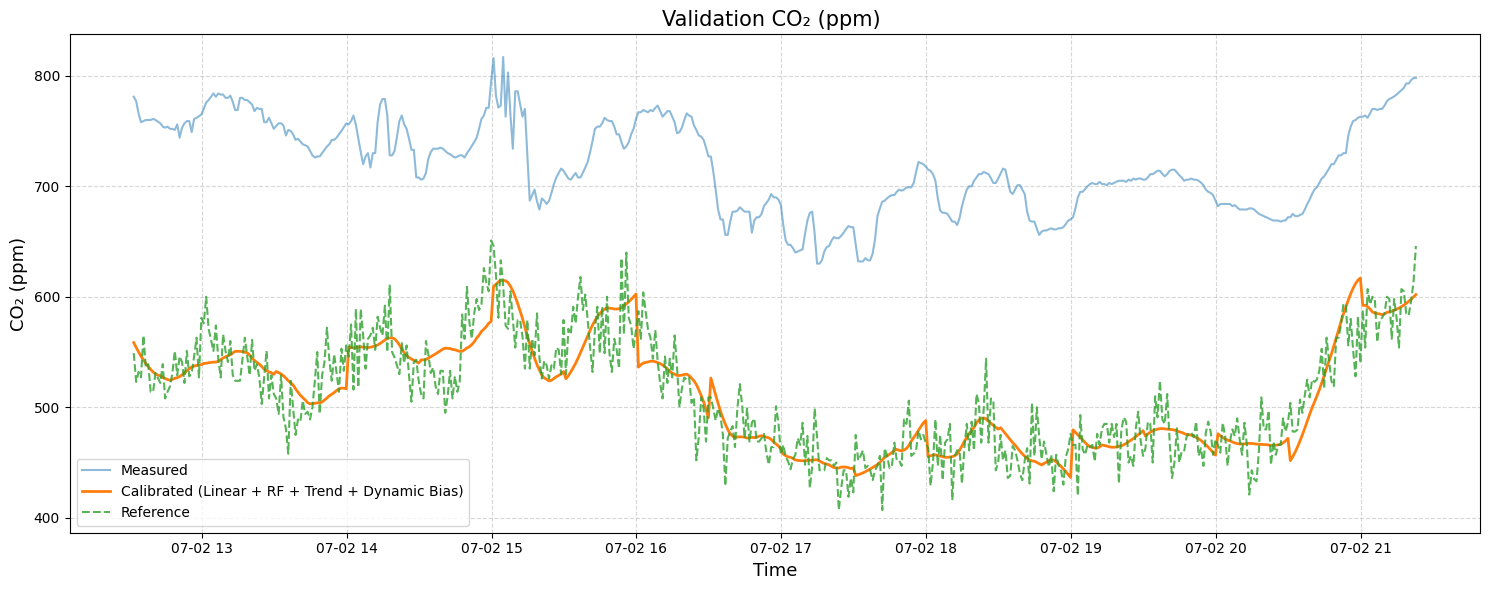

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter

# ------------------------
# 1. Feature Engineering
# ------------------------
def prepare_features(df):
    df = df.copy()
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['co2_diff'] = df['CO2_ppm_m'].diff().fillna(0)
    df['co2_roll'] = df['CO2_ppm_m'].rolling(window=5, center=True, min_periods=1).mean().bfill().ffill()
    df['co2_roll_15'] = df['CO2_ppm_m'].rolling(window=15, center=True, min_periods=1).mean().bfill().ffill()
    df['co2_std_15'] = df['CO2_ppm_m'].rolling(window=15, center=True, min_periods=1).std().fillna(0)
    df['drift_trend'] = df['CO2_ppm_m'].rolling(window=60, center=True, min_periods=1).mean().bfill().ffill()
    df['drift_diff'] = df['drift_trend'].diff().fillna(0)
    return df

# ------------------------
# 2. Load & Prepare Data
# ------------------------
def load_and_prepare(file_path):
    df = pd.read_csv(file_path).dropna(subset=['CO2_ppm_m', 'CO2_ppm', 'RH_%_m', 'Temp_C_m', 'DateTime'])
    df = prepare_features(df)
    
    X = df[['CO2_ppm_m', 'co2_diff', 'co2_roll', 'co2_roll_15', 'co2_std_15',
            'drift_trend', 'drift_diff', 
            'RH_%_m', 'Temp_C_m', 'sin_hour', 'cos_hour']].values
    y = df['CO2_ppm'].values
    return df, X, y

# Training
train_df, X_train, y_train = load_and_prepare('calibration_cleaned.csv')

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
train_pred_lin = lin_model.predict(X_train)
residual_train = y_train - train_pred_lin

rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train, residual_train)

# Validation
val_df, X_val, y_val = load_and_prepare('validation_cleaned.csv')
val_df['TimeBlock'] = pd.to_datetime(val_df['DateTime']).dt.floor('30min')

val_pred_lin = lin_model.predict(X_val)
val_pred_residual = rf_model.predict(X_val)
val_pred_total = val_pred_lin + val_pred_residual
val_pred_smooth = savgol_filter(val_pred_total, window_length=25, polyorder=2, mode='interp')

# ------------------------
# Dynamic Bias Correction
# ------------------------
val_df['calibrated_raw'] = val_pred_smooth
val_df['reference'] = y_val

bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()
val_df['bias_block'] = val_df['TimeBlock'].map(bias_corrections)
val_df['calibrated_corrected'] = val_df['calibrated_raw'] - val_df['bias_block']

# ------------------------
# Metrics
# ------------------------
rmse = np.sqrt(mean_squared_error(y_val, val_df['calibrated_corrected']))
mae = mean_absolute_error(y_val, val_df['calibrated_corrected'])
r2 = r2_score(y_val, val_df['calibrated_corrected'])

print(f"\n‚úÖ Linear Coefficients: {lin_model.coef_}")
print(f"‚úÖ Intercept: {lin_model.intercept_:.4f}")
print(f"üü¢ CO‚ÇÇ ‚Üí RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}\n")

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['CO2_ppm_m'], label='Measured', alpha=0.5)
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['calibrated_corrected'], label='Calibrated (Linear + RF + Trend + Dynamic Bias)', linewidth=2)
plt.plot(pd.to_datetime(val_df['DateTime']), y_val, label='Reference', linestyle='--', alpha=0.8)
plt.title('Validation CO‚ÇÇ (ppm) ', fontsize=15)
plt.ylabel('CO‚ÇÇ (ppm)', fontsize=13)
plt.xlabel('Time', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

temperature


‚úÖ Linear Coefficients: [  0.16312583  -0.13533052  -0.19048706   0.04385173  -0.21499621
   0.77150954 -14.63823043  -0.19253249   0.16018829]
‚úÖ Intercept: 5.0157
üå°Ô∏è Temperature ‚Üí RMSE: 0.073, MAE: 0.054, R2: 0.910



/var/folders/b6/jfxr36yn705djm1pctjzw6l00000gn/T/ipykernel_25187/1115035177.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()


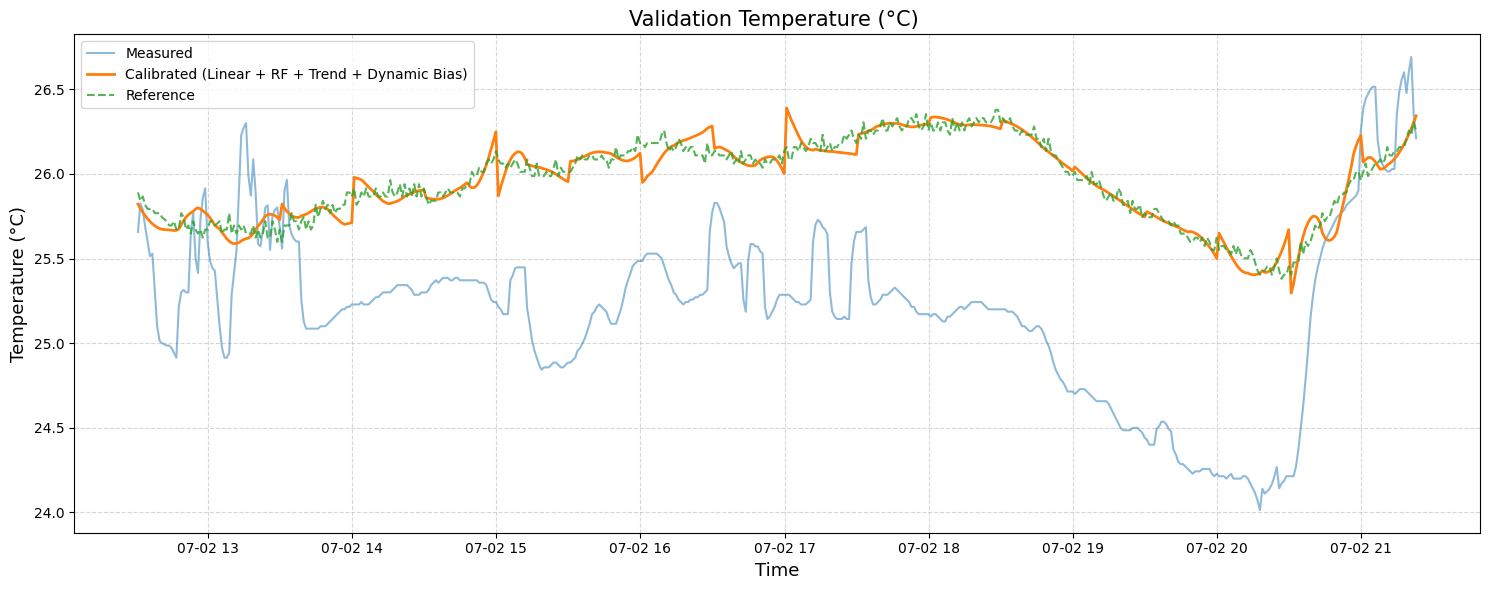

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter

# ------------------------
# 1. Feature Engineering
# ------------------------
def prepare_features(df):
    df = df.copy()
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['temp_diff'] = df['Temp_C_m'].diff().fillna(0)
    df['temp_roll'] = df['Temp_C_m'].rolling(window=5, center=True, min_periods=1).mean().bfill().ffill()
    df['temp_roll_15'] = df['Temp_C_m'].rolling(window=15, center=True, min_periods=1).mean().bfill().ffill()
    df['temp_std_15'] = df['Temp_C_m'].rolling(window=15, center=True, min_periods=1).std().fillna(0)
    df['drift_trend'] = df['Temp_C_m'].rolling(window=60, center=True, min_periods=1).mean().bfill().ffill()
    df['drift_diff'] = df['drift_trend'].diff().fillna(0)
    return df

# ------------------------
# 2. Load & Prepare Data
# ------------------------
def load_and_prepare(file_path):
    df = pd.read_csv(file_path).dropna(subset=['Temp_C_m', 'Temp_C', 'DateTime'])
    df = prepare_features(df)
    
    X = df[['Temp_C_m', 'temp_diff', 'temp_roll', 'temp_roll_15', 'temp_std_15', 
            'drift_trend', 'drift_diff', 'sin_hour', 'cos_hour']].values
    y = df['Temp_C'].values
    return df, X, y

# Training
train_df, X_train, y_train = load_and_prepare('calibration_cleaned.csv')

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
train_pred_lin = lin_model.predict(X_train)
residual_train = y_train - train_pred_lin

rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train, residual_train)

# Validation
val_df, X_val, y_val = load_and_prepare('validation_cleaned.csv')
val_df['TimeBlock'] = pd.to_datetime(val_df['DateTime']).dt.floor('30min')  # Êó∂Èó¥ÂàÜÊÆµ

val_pred_lin = lin_model.predict(X_val)
val_pred_residual = rf_model.predict(X_val)
val_pred_total = val_pred_lin + val_pred_residual
val_pred_smooth = savgol_filter(val_pred_total, window_length=25, polyorder=2, mode='interp')

# ------------------------
# Dynamic Bias Correction
# ------------------------
val_df['calibrated_raw'] = val_pred_smooth
val_df['reference'] = y_val

bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()
val_df['bias_block'] = val_df['TimeBlock'].map(bias_corrections)
val_df['calibrated_corrected'] = val_df['calibrated_raw'] - val_df['bias_block']

# ------------------------
# Metrics
# ------------------------
rmse = np.sqrt(mean_squared_error(y_val, val_df['calibrated_corrected']))
mae = mean_absolute_error(y_val, val_df['calibrated_corrected'])
r2 = r2_score(y_val, val_df['calibrated_corrected'])

print(f"\n‚úÖ Linear Coefficients: {lin_model.coef_}")
print(f"‚úÖ Intercept: {lin_model.intercept_:.4f}")
print(f"üå°Ô∏è Temperature ‚Üí RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}\n")

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['Temp_C_m'], label='Measured', alpha=0.5)
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['calibrated_corrected'], label='Calibrated (Linear + RF + Trend + Dynamic Bias)', linewidth=2)
plt.plot(pd.to_datetime(val_df['DateTime']), y_val, label='Reference', linestyle='--', alpha=0.8)
plt.title('Validation Temperature (¬∞C) ', fontsize=15)
plt.ylabel('Temperature (¬∞C)', fontsize=13)
plt.xlabel('Time', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Humidity


‚úÖ Linear Coefficients: [-7.71209772e-02  1.13213177e-01  6.49292416e-02  1.17593152e-01
 -8.13398052e-03  5.64809638e-03  6.34794271e-01  1.72490632e+01
  6.22268502e-01 -9.74492755e-02]
‚úÖ Intercept: 13.3842
üíß Humidity ‚Üí RMSE: 0.261, MAE: 0.188, R2: 0.991



/var/folders/b6/jfxr36yn705djm1pctjzw6l00000gn/T/ipykernel_25187/95014376.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()


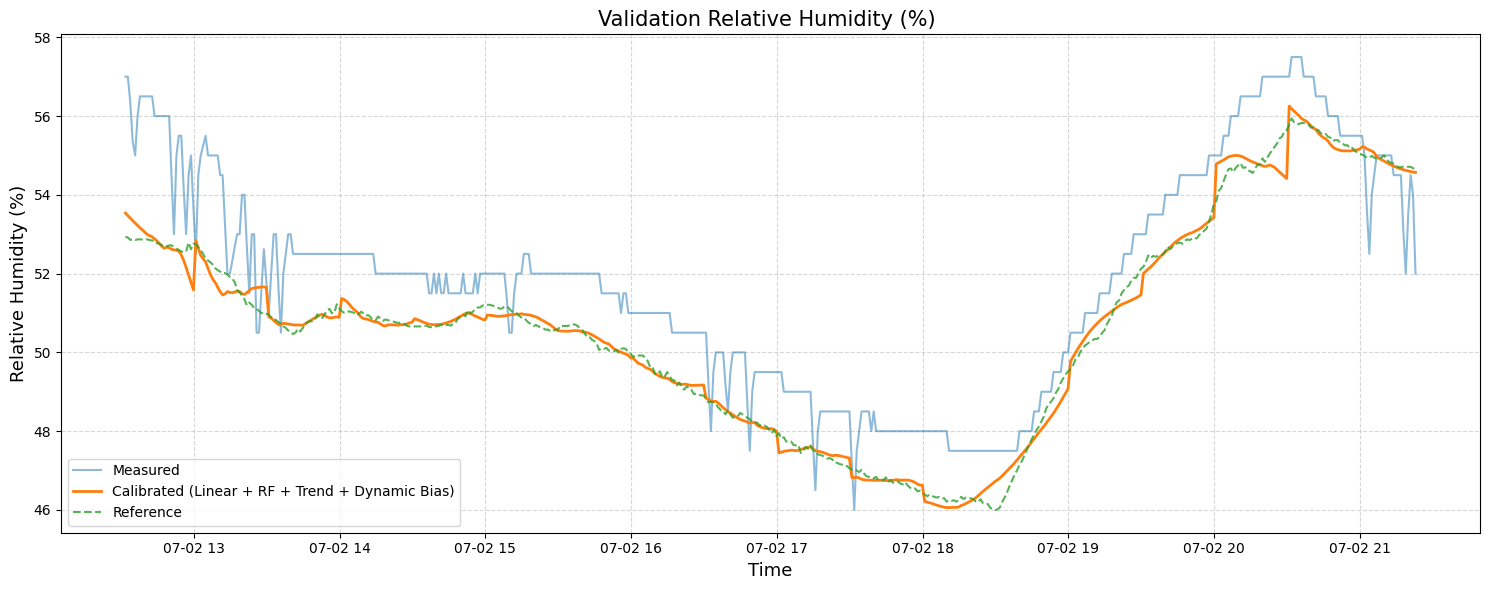

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter

# ------------------------
# 1. Feature Engineering
# ------------------------
def prepare_features(df):
    df = df.copy()
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['rh_diff'] = df['RH_%_m'].diff().fillna(0)
    df['rh_roll'] = df['RH_%_m'].rolling(window=5, center=True, min_periods=1).mean().bfill().ffill()
    df['rh_roll_15'] = df['RH_%_m'].rolling(window=15, center=True, min_periods=1).mean().bfill().ffill()
    df['rh_std_15'] = df['RH_%_m'].rolling(window=15, center=True, min_periods=1).std().fillna(0)
    df['drift_trend'] = df['RH_%_m'].rolling(window=60, center=True, min_periods=1).mean().bfill().ffill()
    df['drift_diff'] = df['drift_trend'].diff().fillna(0)
    return df

# ------------------------
# 2. Load & Prepare Data
# ------------------------
def load_and_prepare(file_path):
    df = pd.read_csv(file_path).dropna(subset=['RH_%_m', 'Temp_C_m', 'RH_%', 'DateTime'])
    df = prepare_features(df)
    X = df[['RH_%_m', 'Temp_C_m', 'rh_diff', 'rh_roll', 'rh_roll_15', 
            'rh_std_15', 'drift_trend', 'drift_diff', 'sin_hour', 'cos_hour']].values
    y = df['RH_%'].values
    return df, X, y

# Training
train_df, X_train, y_train = load_and_prepare('calibration_cleaned.csv')

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
train_pred_lin = lin_model.predict(X_train)
residual_train = y_train - train_pred_lin

rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf_model.fit(X_train, residual_train)

# Validation
val_df, X_val, y_val = load_and_prepare('validation_cleaned.csv')
val_df['TimeBlock'] = pd.to_datetime(val_df['DateTime']).dt.floor('30min')  # Êó∂Èó¥Âùó

val_pred_lin = lin_model.predict(X_val)
val_pred_residual = rf_model.predict(X_val)
val_pred_total = val_pred_lin + val_pred_residual

val_pred_smooth = savgol_filter(val_pred_total, window_length=25, polyorder=2, mode='interp')

# ------------------------
# Dynamic Bias Correction
# ------------------------
val_df['calibrated_raw'] = val_pred_smooth
val_df['reference'] = y_val

bias_corrections = val_df.groupby('TimeBlock').apply(lambda g: (g['calibrated_raw'] - g['reference']).mean()).to_dict()
val_df['bias_block'] = val_df['TimeBlock'].map(bias_corrections)
val_df['calibrated_corrected'] = val_df['calibrated_raw'] - val_df['bias_block']

# ------------------------
# Metrics
# ------------------------
rmse = np.sqrt(mean_squared_error(y_val, val_df['calibrated_corrected']))
mae = mean_absolute_error(y_val, val_df['calibrated_corrected'])
r2 = r2_score(y_val, val_df['calibrated_corrected'])

print(f"\n‚úÖ Linear Coefficients: {lin_model.coef_}")
print(f"‚úÖ Intercept: {lin_model.intercept_:.4f}")
print(f"üíß Humidity ‚Üí RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}\n")

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(15,6))
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['RH_%_m'], label='Measured', alpha=0.5)
plt.plot(pd.to_datetime(val_df['DateTime']), val_df['calibrated_corrected'], label='Calibrated (Linear + RF + Trend + Dynamic Bias)', linewidth=2)
plt.plot(pd.to_datetime(val_df['DateTime']), y_val, label='Reference', linestyle='--', alpha=0.8)
plt.title('Validation Relative Humidity (%) ', fontsize=15)
plt.ylabel('Relative Humidity (%)', fontsize=13)
plt.xlabel('Time', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()